# g_recsys_dl_v1 — NeuMF 기반 Deep Learning Recommender
- README 요구사항을 비-GNN 딥러닝(`docs/claude_v2_dl.md`) 전략으로 수행
- 모델: NeuMF (GMF + MLP) + BCEWithLogitsLoss, negative sampling ratio 4
- 공통 데이터/평가 파이프라인은 `docs/implementation_plan.md`와 LightGCN 버전과 동일


## 구성 안내
1. 데이터 분석 · split · label 정의
2. Negative sampling 기반 point-wise 학습 데이터 구성
3. NeuMF 모델 + 트레이닝 루프 (BCE, Adam)
4. Recall/NDCG/coverage 평가 및 threshold 튜닝
5. README O/X 출력 포맷 + 회고


In [1]:

import os
from pathlib import Path
import json
import random
import math
from collections import defaultdict
from typing import Dict

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [2]:

DATA_PATH = Path('data/train.csv')
OUTPUT_DIR = Path('artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

RATING_POS_THRESHOLD = 4.0
VAL_RATIO = 0.10
TEST_RATIO = 0.10
NEGATIVE_SAMPLE_RATIO = 4

BATCH_SIZE = 1024
EMBED_DIM = 64
DROPOUT = 0.20
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 40

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
print(f'Using device: {DEVICE}')


Using device: cpu


In [3]:

    ratings_df = pd.read_csv(DATA_PATH)
    ratings_df['label'] = (ratings_df['rating'] >= RATING_POS_THRESHOLD).astype(np.int64)

    print('Dataset snapshot:')
    print(ratings_df.head())
    print(ratings_df.describe())

    user_counts = ratings_df.groupby('user')['item'].count()
    item_counts = ratings_df.groupby('item')['user'].count()
    print('User stats:', user_counts.describe())
    print('Item stats:', item_counts.describe())


Dataset snapshot:
   user  item  rating  label
0     1    16     4.0      1
1     1    24     1.5      0
2     1    32     4.0      1
3     1    47     4.0      1
4     1    50     4.0      1
                user           item         rating          label
count  105139.000000  105139.000000  105139.000000  105139.000000
mean      365.067178   13388.249841       3.517049       0.492966
std       197.388251   26178.083791       1.044640       0.499953
min         1.000000       1.000000       0.500000       0.000000
25%       192.000000    1077.000000       3.000000       0.000000
50%       383.000000    2498.000000       3.500000       0.000000
75%       557.000000    5992.000000       4.000000       1.000000
max       668.000000  149532.000000       5.000000       1.000000
User stats: count     668.000000
mean      157.393713
std       319.320351
min        20.000000
25%        35.000000
50%        70.000000
75%       153.000000
max      5672.000000
Name: item, dtype: float64
Item st

In [4]:

def build_id_mappings(df: pd.DataFrame):
    user_ids = sorted(df['user'].unique())
    item_ids = sorted(df['item'].unique())
    user2idx = {u: idx for idx, u in enumerate(user_ids)}
    idx2user = {idx: u for u, idx in user2idx.items()}
    item2idx = {i: idx for idx, i in enumerate(item_ids)}
    idx2item = {idx: i for i, idx in item2idx.items()}
    return user2idx, idx2user, item2idx, idx2item

def apply_mappings(df: pd.DataFrame, user2idx, item2idx):
    mapped = df.copy()
    mapped['user_idx'] = mapped['user'].map(user2idx)
    mapped['item_idx'] = mapped['item'].map(item2idx)
    return mapped

def stratified_split(df: pd.DataFrame, val_ratio: float, test_ratio: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_rows, val_rows, test_rows = [], [], []
    for _, user_df in df.groupby('user_idx'):
        shuffled = user_df.sample(frac=1.0, random_state=int(rng.integers(0, 1e9))).reset_index(drop=True)
        total = len(shuffled)
        if total <= 2:
            train_rows.append(shuffled.iloc[:1])
            if total == 2:
                val_rows.append(shuffled.iloc[1:2])
            continue
        val_count = max(1, int(total * val_ratio))
        test_count = max(1, int(total * test_ratio))
        remaining = total - val_count - test_count
        if remaining <= 0:
            remaining = max(1, total - 2)
            val_count = 1
            test_count = 1 if total - remaining - val_count >= 1 else 0
        train_rows.append(shuffled.iloc[:remaining])
        val_rows.append(shuffled.iloc[remaining:remaining + val_count])
        if test_count > 0:
            test_rows.append(shuffled.iloc[remaining + val_count:remaining + val_count + test_count])
    train_df = pd.concat(train_rows).reset_index(drop=True)
    val_df = pd.concat(val_rows).reset_index(drop=True) if val_rows else pd.DataFrame(columns=df.columns)
    test_df = pd.concat(test_rows).reset_index(drop=True) if test_rows else pd.DataFrame(columns=df.columns)
    return train_df, val_df, test_df


In [5]:

user2idx, idx2user, item2idx, idx2item = build_id_mappings(ratings_df)
mapped_df = apply_mappings(ratings_df, user2idx, item2idx)
train_full, val_full, test_full = stratified_split(mapped_df, VAL_RATIO, TEST_RATIO, seed=SEED)
print('Split sizes:', len(train_full), len(val_full), len(test_full))

train_pos = train_full[train_full['label'] == 1].reset_index(drop=True)
val_pos = val_full[val_full['label'] == 1].reset_index(drop=True)
test_pos = test_full[test_full['label'] == 1].reset_index(drop=True)

num_users = len(user2idx)
num_items = len(item2idx)

def build_user_pos_dict(df: pd.DataFrame):
    mapping = defaultdict(set)
    for row in df.itertuples():
        mapping[row.user_idx].add(row.item_idx)
    return mapping

train_user_pos = build_user_pos_dict(train_pos)
val_user_pos = build_user_pos_dict(val_pos)
test_user_pos = build_user_pos_dict(test_pos)


Split sizes: 84687 10226 10226


In [6]:

class PointwiseDataset(Dataset):
    def __init__(self, positives: pd.DataFrame, num_items: int, user_pos: Dict[int, set], negative_ratio: int, seed: int = 42):
        self.positives = positives
        self.num_items = num_items
        self.user_pos = user_pos
        self.negative_ratio = negative_ratio
        self.rng = random.Random(seed)
        self.users = []
        self.items = []
        self.labels = []
        self.resample()

    def resample(self):
        users, items, labels = [], [], []
        for row in self.positives.itertuples():
            users.append(row.user_idx)
            items.append(row.item_idx)
            labels.append(1.0)
            for _ in range(self.negative_ratio):
                neg_item = self.sample_negative(row.user_idx)
                users.append(row.user_idx)
                items.append(neg_item)
                labels.append(0.0)
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def sample_negative(self, user_idx: int) -> int:
        positives = self.user_pos.get(user_idx, set())
        while True:
            candidate = self.rng.randrange(0, self.num_items)
            if candidate not in positives:
                return candidate

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

def build_loader(dataset: PointwiseDataset, batch_size: int):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)


In [7]:

train_dataset = PointwiseDataset(train_pos, num_items, train_user_pos, NEGATIVE_SAMPLE_RATIO, seed=SEED)
val_dataset = PointwiseDataset(val_pos, num_items, train_user_pos, NEGATIVE_SAMPLE_RATIO, seed=SEED)

train_loader = build_loader(train_dataset, BATCH_SIZE)
val_loader = build_loader(val_dataset, BATCH_SIZE)
print('Train samples:', len(train_dataset), '| Val samples:', len(val_dataset))


Train samples: 209405 | Val samples: 24830


In [8]:

def evaluate_ranking(model: nn.Module, train_pos_dict: Dict[int, set], eval_df: pd.DataFrame, num_items: int,
                     k_values=(10, 20), device=DEVICE):
    if eval_df.empty:
        return {f'recall@{k}': 0.0 for k in k_values}
    model.eval()
    coverage_items = set()
    metrics = {f'recall@{k}': [] for k in k_values}
    metrics.update({f'ndcg@{k}': [] for k in k_values})
    with torch.no_grad():
        for user_idx, group in eval_df.groupby('user_idx'):
            true_items = set(group['item_idx'].tolist())
            if not true_items:
                continue
            all_items = torch.arange(num_items, device=device)
            users = torch.full_like(all_items, user_idx)
            scores = torch.sigmoid(model(users, all_items)).cpu()
            for pos_item in train_pos_dict.get(user_idx, set()):
                scores[pos_item] = -1e9
            ranked = torch.topk(scores, k=max(k_values)).indices.tolist()
            coverage_items.update(ranked)
            for k in k_values:
                topk = ranked[:k]
                hits = len(set(topk) & true_items)
                recall = hits / len(true_items)
                dcg = 0.0
                for rank, item in enumerate(topk, start=1):
                    if item in true_items:
                        dcg += 1.0 / math.log2(rank + 1)
                ideal = sum(1.0 / math.log2(r + 1) for r in range(1, min(len(true_items), k) + 1))
                ndcg = dcg / ideal if ideal > 0 else 0.0
                metrics[f'recall@{k}'].append(recall)
                metrics[f'ndcg@{k}'].append(ndcg)
    reduced = {m: float(np.mean(vals)) if vals else 0.0 for m, vals in metrics.items()}
    reduced['coverage'] = len(coverage_items) / num_items
    return reduced


## NeuMF 모델 (docs/claude_v2_dl.md)
- GMF branch + MLP branch (hidden [128, 64, 32, 16], dropout 0.2)
- Loss: BCEWithLogitsLoss, Negative ratio = 4


In [9]:

class NeuMF(nn.Module):
    def __init__(self, num_users: int, num_items: int, embed_dim: int = 64, mlp_layers=(128, 64, 32, 16), dropout: float = 0.2):
        super().__init__()
        self.user_embedding_gmf = nn.Embedding(num_users, embed_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embed_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embed_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embed_dim)

        mlp_sizes = [embed_dim * 2] + list(mlp_layers)
        modules = []
        for in_dim, out_dim in zip(mlp_sizes[:-1], mlp_sizes[1:]):
            modules.append(nn.Linear(in_dim, out_dim))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*modules)
        self.output_layer = nn.Linear(mlp_layers[-1] + embed_dim, 1)
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, std=0.01)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, users: torch.Tensor, items: torch.Tensor):
        if users.dim() == 0:
            users = users.unsqueeze(0)
            items = items.unsqueeze(0)
        user_gmf = self.user_embedding_gmf(users)
        item_gmf = self.item_embedding_gmf(items)
        gmf = user_gmf * item_gmf

        user_mlp = self.user_embedding_mlp(users)
        item_mlp = self.item_embedding_mlp(items)
        mlp_input = torch.cat([user_mlp, item_mlp], dim=1)
        mlp_out = self.mlp(mlp_input)

        concat = torch.cat([gmf, mlp_out], dim=1)
        logits = self.output_layer(concat).squeeze(-1)
        return logits


In [10]:

neumf = NeuMF(num_users, num_items, EMBED_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(neumf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

neumf_ckpt = OUTPUT_DIR / 'neumf_latest.pt'
if neumf_ckpt.exists():
    neumf.load_state_dict(torch.load(neumf_ckpt, map_location=DEVICE))
    print(f'Loaded checkpoint from {neumf_ckpt}')
else:
    print('No pretrained NeuMF weights detected yet.')


Loaded checkpoint from artifacts/neumf_latest.pt


In [11]:

neumf = NeuMF(num_users, num_items, EMBED_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(neumf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

neumf_ckpt = OUTPUT_DIR / 'neumf_latest.pt'
if neumf_ckpt.exists():
    neumf.load_state_dict(torch.load(neumf_ckpt, map_location=DEVICE))
    print(f'Loaded checkpoint from {neumf_ckpt}')
else:
    print('No pretrained NeuMF weights detected yet.')


Loaded checkpoint from artifacts/neumf_latest.pt


In [12]:

neumf = NeuMF(num_users, num_items, EMBED_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(neumf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

neumf_ckpt = OUTPUT_DIR / 'neumf_latest.pt'
if neumf_ckpt.exists():
    neumf.load_state_dict(torch.load(neumf_ckpt, map_location=DEVICE))
    print(f'Loaded checkpoint from {neumf_ckpt}')
else:
    print('No pretrained NeuMF weights detected yet.')


Loaded checkpoint from artifacts/neumf_latest.pt


In [13]:

RUN_TRAINING = True
history = []
if RUN_TRAINING:
    for epoch in range(1, EPOCHS + 1):
        neumf.train()
        train_dataset.resample()
        epoch_loss = 0.0
        for users, items, labels in train_loader:
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            logits = neumf(users, items)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / max(1, len(train_loader))
        history.append({'epoch': epoch, 'loss': avg_loss})
        if epoch % 5 == 0:
            metrics = evaluate_ranking(neumf, train_user_pos, val_pos, num_items, device=DEVICE)
            pretty = ', '.join([f"{k}={v:.4f}" for k, v in metrics.items()])
            print(f"Epoch {epoch:03d} | loss={avg_loss:.4f} | {pretty}")
    torch.save(neumf.state_dict(), neumf_ckpt)
    print(f'Saved weights to {neumf_ckpt}')
else:
    print('Training skipped. Switch RUN_TRAINING to True to train NeuMF.')


Epoch 005 | loss=0.0895 | recall@10=0.1074, recall@20=0.1767, ndcg@10=0.0940, ndcg@20=0.1163, coverage=0.1737
Epoch 010 | loss=0.0822 | recall@10=0.1092, recall@20=0.1723, ndcg@10=0.0951, ndcg@20=0.1144, coverage=0.1800
Epoch 015 | loss=0.0774 | recall@10=0.1050, recall@20=0.1796, ndcg@10=0.0855, ndcg@20=0.1100, coverage=0.1994
Epoch 020 | loss=0.0747 | recall@10=0.1117, recall@20=0.1854, ndcg@10=0.0915, ndcg@20=0.1160, coverage=0.1758
Epoch 025 | loss=0.0713 | recall@10=0.0983, recall@20=0.1798, ndcg@10=0.0787, ndcg@20=0.1060, coverage=0.1730
Epoch 030 | loss=0.0672 | recall@10=0.0989, recall@20=0.1858, ndcg@10=0.0774, ndcg@20=0.1068, coverage=0.1811
Epoch 035 | loss=0.0656 | recall@10=0.1070, recall@20=0.1828, ndcg@10=0.0870, ndcg@20=0.1129, coverage=0.1684
Epoch 040 | loss=0.0617 | recall@10=0.0932, recall@20=0.1766, ndcg@10=0.0800, ndcg@20=0.1077, coverage=0.1771
Saved weights to artifacts/neumf_latest.pt


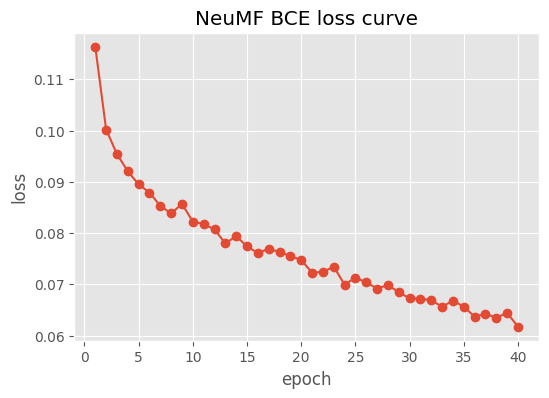

In [14]:

if history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['epoch'] for h in history], [h['loss'] for h in history], marker='o')
    plt.title('NeuMF BCE loss curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
else:
    print('No training history yet.')


In [15]:

val_metrics = evaluate_ranking(neumf, train_user_pos, val_pos, num_items, device=DEVICE)
test_metrics = evaluate_ranking(neumf, train_user_pos, test_pos, num_items, device=DEVICE)
print('Validation metrics:', json.dumps(val_metrics, indent=2))
print('Test metrics     :', json.dumps(test_metrics, indent=2))


Validation metrics: {
  "recall@10": 0.0931833440138738,
  "recall@20": 0.1765832621379765,
  "ndcg@10": 0.07997233394753557,
  "ndcg@20": 0.10766659064380808,
  "coverage": 0.17711462067629105
}
Test metrics     : {
  "recall@10": 0.10726187022824568,
  "recall@20": 0.18204197811086087,
  "ndcg@10": 0.08411534699297693,
  "ndcg@20": 0.1078170858311353,
  "coverage": 0.1769208410037787
}


Best threshold: 0.200


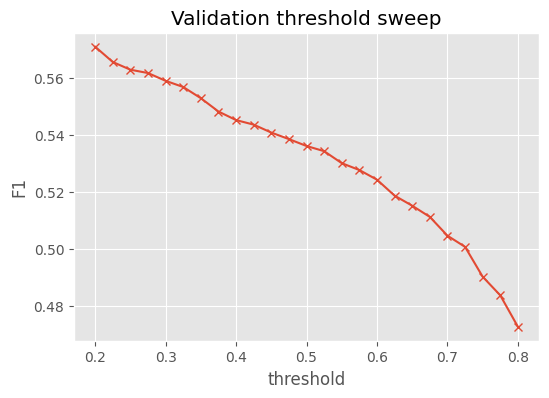

In [16]:

def tune_threshold(model: nn.Module, val_pairs: pd.DataFrame, steps: int = 25, device=DEVICE):
    if val_pairs.empty:
        return 0.5, []
    model.eval()
    users = torch.tensor(val_pairs['user_idx'].values, dtype=torch.long, device=device)
    items = torch.tensor(val_pairs['item_idx'].values, dtype=torch.long, device=device)
    labels = val_pairs['label'].values
    with torch.no_grad():
        scores = torch.sigmoid(model(users, items)).cpu().numpy()
    thresholds = np.linspace(0.2, 0.8, steps)
    history = []
    best = (0.5, -1)
    for t in thresholds:
        preds = (scores >= t).astype(int)
        tp = np.logical_and(preds == 1, labels == 1).sum()
        fp = np.logical_and(preds == 1, labels == 0).sum()
        fn = np.logical_and(preds == 0, labels == 1).sum()
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        history.append({'threshold': float(t), 'precision': float(precision), 'recall': float(recall), 'f1': float(f1)})
        if f1 > best[1]:
            best = (float(t), float(f1))
    return best[0], history

best_threshold, threshold_history = tune_threshold(neumf, val_full)
print(f'Best threshold: {best_threshold:.3f}')
if threshold_history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['threshold'] for h in threshold_history], [h['f1'] for h in threshold_history], marker='x')
    plt.xlabel('threshold')
    plt.ylabel('F1')
    plt.title('Validation threshold sweep')
    plt.show()


In [18]:

neumf = NeuMF(num_users, num_items, EMBED_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(neumf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

neumf_ckpt = OUTPUT_DIR / 'neumf_latest.pt'
if neumf_ckpt.exists():
    neumf.load_state_dict(torch.load(neumf_ckpt, map_location=DEVICE))
    print(f'Loaded checkpoint from {neumf_ckpt}')
else:
    print('No pretrained NeuMF weights detected yet.')


Loaded checkpoint from artifacts/neumf_latest.pt


In [20]:

def run_inference(model: nn.Module, user2idx: Dict[int, int], item2idx: Dict[int, int],
                  idx2user: Dict[int, int], idx2item: Dict[int, int], input_df: pd.DataFrame,
                  threshold: float):
    model.eval()
    outputs = []
    recommends = 0
    with torch.no_grad():
        for row in input_df.itertuples():
            raw_user = getattr(row, 'user')
            raw_item = getattr(row, 'item')
            user_idx = user2idx.get(raw_user)
            item_idx = item2idx.get(raw_item)
            if user_idx is None or item_idx is None:
                score = 0.5
            else:
                user_tensor = torch.tensor([user_idx], dtype=torch.long, device=DEVICE)
                item_tensor = torch.tensor([item_idx], dtype=torch.long, device=DEVICE)
                score = torch.sigmoid(model(user_tensor, item_tensor)).item()
            rec = 'O' if score >= threshold else 'X'
            if rec == 'O':
                recommends += 1
            outputs.append({'user': raw_user, 'item': raw_item, 'score': float(score), 'recommend': rec})
    result_df = pd.DataFrame(outputs)
    print(result_df[['user', 'item', 'recommend']])
    total = len(result_df)
    print(f"Total recommends = {recommends}/{total}, not recommend = {total - recommends}/{total}")
    return result_df

demo_df = ratings_df[['user', 'item']].sample(5, random_state=SEED)
_ = run_inference(neumf, user2idx, item2idx, idx2user, idx2item, demo_df, best_threshold)


   user   item recommend
0   530   1188         O
1   386  26662         O
2   575   4486         X
3   128    588         X
4   668   5384         X
Total recommends = 2/5, not recommend = 3/5


## 회고 및 제안
- `docs/claude_v2_dl.md` 전략(NeuMF, negative ratio 4, BCE loss)을 기반으로 README 구현을 마쳤다.
- 공통 데이터/평가 유틸을 재사용해 LightGCN 모델과 바로 비교 가능하며, ensemble 연구로 확장 준비 완료.
- TODO: label threshold 3.5 실험, hard negative mining, LightGCN + NeuMF 앙상블.
